In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import datetime

import warnings
warnings.filterwarnings('ignore')

In [116]:
fp = "https://raw.githubusercontent.com/atharv-github/ENSO-ML/main/Copy%20of%20Warm_Water_Volume.csv"
data = pd.read_csv(fp, parse_dates=['Date'])#, index_col='Date')
print(data.shape)
data

(520, 4)


,Date,Anomaly,Anomaly fit,ENSO val
0,1980-01-01,7.660000e+13,0.766,0.6
1,1980-01-02,7.000000e+13,0.700,0.5
2,1980-01-03,5.240000e+13,0.524,0.3
3,1980-01-04,4.010000e+13,0.401,0.4
4,1980-01-05,4.020000e+13,0.402,0.5
...,...,...,...,...
515,2022-01-12,1.560000e+14,1.560,-0.8
516,2023-01-01,1.760000e+14,1.760,-0.7
517,2023-01-02,1.870000e+14,1.870,-0.4
518,2023-01-03,1.970000e+14,1.970,-0.1


In [117]:
data=data.rename(columns={"Anomaly fit":"WWV Anomaly fit"})
data.dtypes

Date               datetime64[ns]
Anomaly                   float64
WWV Anomaly fit           float64
ENSO val                  float64
dtype: object

In [118]:
ad_fuller_result_1 = adfuller(data['WWV Anomaly fit'])

print('WWV Anomaly')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(data['ENSO val'])

print('ENSO val')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

WWV Anomaly
ADF Statistic: -5.453560663254444
p-value: 2.611801630538864e-06

---------------------

ENSO val
ADF Statistic: -5.714709575367639
p-value: 7.165183174621446e-07


The data provided is STATIONARY because the p values for ADF test are less than 0.05. Thus, we dont have to manipulate the data anymore. We can apply the test directly now.

In [119]:
print('WWV Anomaly causes ENSO val?\n')
print('------------------')
granger_1 = grangercausalitytests(data[['ENSO val', 'WWV Anomaly fit']], 2)

print('\nENSO val causes WWV Anomaly?\n')
print('------------------')
granger_2 = grangercausalitytests(data[['WWV Anomaly fit', 'ENSO val']], 2)

WWV Anomaly causes ENSO val?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=294.2284, p=0.0000  , df_denom=516, df_num=1
ssr based chi2 test:   chi2=295.9391, p=0.0000  , df=1
likelihood ratio test: chi2=234.1777, p=0.0000  , df=1
parameter F test:         F=294.2284, p=0.0000  , df_denom=516, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=44.6317 , p=0.0000  , df_denom=513, df_num=2
ssr based chi2 test:   chi2=90.1335 , p=0.0000  , df=2
likelihood ratio test: chi2=83.0971 , p=0.0000  , df=2
parameter F test:         F=44.6317 , p=0.0000  , df_denom=513, df_num=2

ENSO val causes WWV Anomaly?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=244.6787, p=0.0000  , df_denom=516, df_num=1
ssr based chi2 test:   chi2=246.1013, p=0.0000  , df=1
likelihood ratio test: chi2=201.4261, p=0.0000  , df=1
parameter F test:         F=244.6787, p=0.0000  , df_denom=516, df_n

Here we have to check the p values for both the cases. Typically if the p values are less than 0.05 we can apply the test scessfully. Since in btoh the cases p values are less than 0.05, we can use VAR test.

In [120]:
data = data[['ENSO val','WWV Anomaly fit']]
print(data.shape)

(520, 2)


Split the training and testing data. Last 20 values for test. Rest are for training.

In [121]:
train_data=data[:-5]
test_data=data[-5:]

In [122]:
print(train_data.shape)
print(test_data.shape)

(515, 2)
(5, 2)


In [123]:
model = VAR(train_data)

In [124]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.2246     -0.2076      0.7989     -0.2179
1       -6.805      -6.754    0.001109      -6.785
2       -8.119      -8.034   0.0002979      -8.086
3       -8.471      -8.352   0.0002095      -8.424
4       -8.570      -8.417   0.0001897      -8.510
5       -8.683     -8.497*   0.0001694     -8.610*
6       -8.689      -8.468   0.0001684      -8.603
7       -8.704      -8.449   0.0001660      -8.604
8       -8.704      -8.416   0.0001658      -8.591
9       -8.727      -8.404   0.0001622      -8.600
10     -8.734*      -8.377  0.0001611*      -8.594
11      -8.727      -8.336   0.0001622      -8.573
12      -8.716      -8.291   0.0001640      -8.549
13      -8.714      -8.256   0.0001642      -8.534
14      -8.719      -8.226   0.0001635      -8.526
15      -8.711      -8.184   0.0001648      -8.504
16      -8.720      -8.159   0.

In [125]:
var_model = VARMAX(train_data, order=(5,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:     ['ENSO val', 'WWV Anomaly fit']   No. Observations:                  515
Model:                                      VAR(5)   Log Likelihood                 786.816
                                       + intercept   AIC                          -1523.632
Date:                             Mon, 17 Jul 2023   BIC                          -1417.528
Time:                                     06:49:05   HQIC                         -1482.049
Sample:                                          0                                         
                                             - 515                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):             0.00, 0.48   Jarque-Bera (JB):          2.92, 19.50
Prob(Q):                        0.98, 0.49   Prob(JB):                   0.23, 0.00
Hete

In [126]:
n_forecast = 5
predict = fitted_model.get_prediction(start=len(train_data),end=len(train_data) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [127]:
predictions.columns=['ENSO val_predicted','WWV Anomaly fit_predicted']
predictions = predictions.drop(['WWV Anomaly fit_predicted'], axis=1)

In [128]:
predictions.dtypes

ENSO val_predicted    float64
dtype: object

In [129]:
test_vs_pred=pd.concat([test_data,predictions],axis=1)

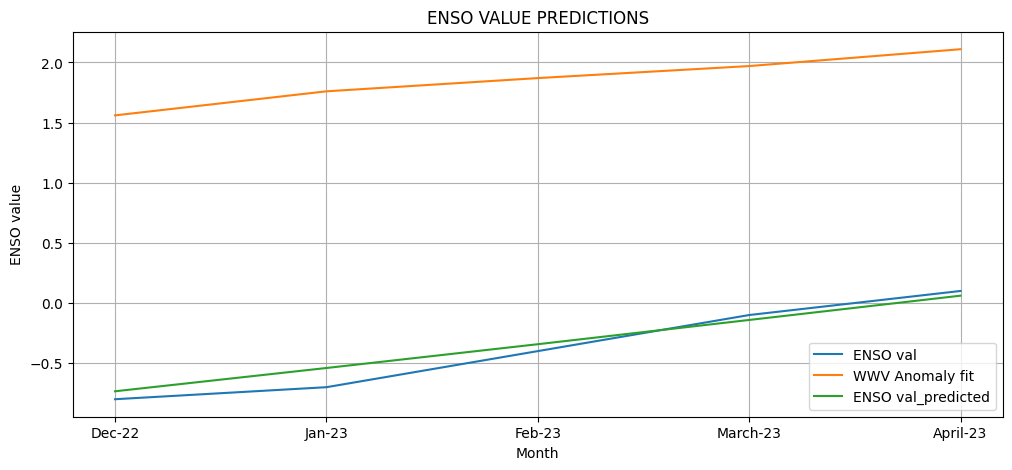

In [130]:
test_vs_pred.plot(figsize=(12,5))
x = [515.0, 516.0, 517.0, 518.0, 519.0]
x_ticks = ["Dec-22", "Jan-23", "Feb-23", "March-23","April-23"]
plt.xticks(x,x_ticks)
plt.title('ENSO VALUE PREDICTIONS')
plt.xlabel('Month')
plt.ylabel('ENSO value')
plt.grid(True)

In [131]:
new_column = ["Dec-22", "Jan-23", "Feb-23", "March-23","April-23"]
predictions['Date'] = new_column

In [132]:
new_column_order=['Date', 'ENSO val_predicted']
predictions = predictions.reindex(columns=new_column_order)
#predicitons.set_index('Date', inplace=True)
predictions

,Date,ENSO val_predicted
515,Dec-22,-0.733945
516,Jan-23,-0.540367
517,Feb-23,-0.342651
518,March-23,-0.141010
519,April-23,0.060854


In [133]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ENSOval=math.sqrt(mean_squared_error(predictions['ENSO val_predicted'],test_data['ENSO val']))
print('Mean value of ENSO val is : {}. Root Mean Squared Error is :{}'.format(mean(test_data['ENSO val']),rmse_ENSOval))

#rmse_anomaly=math.sqrt(mean_squared_error(predictions['WWV Anomaly fit_predicted'],test_data['WWV Anomaly fit']))
#print('Mean value of WWV Anomaly fit is : {}. Root Mean Squared Error is :{}'.format(mean(test_data['WWV Anomaly fit']),rmse_anomaly))

Mean value of ENSO val is : -0.38. Root Mean Squared Error is :0.08526312157897298


Please note that the WWV Anomaly fit here referst to the Warm Water
Anomaly data that is divided by 10 raised to 14, so that it fits the ENSO data.